In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt

# Load the data

In [2]:
print(f"[INFO] Current working directory: {os.getcwd()}")

[INFO] Current working directory: c:\Users\Studen\Documents\vscode_projects\kaggleCompetitions\Titanic


### Train data

In [3]:
train_data_path = Path('titanic_dataset/train.csv')

In [4]:
train_df = pd.read_csv(train_data_path, index_col='PassengerId')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
women = train_df.loc[train_df.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)
print(f"[INFO] Percentage of women who survived: {rate_women:.4%}")

[INFO] Percentage of women who survived: 74.2038%


In [6]:
men = train_df.loc[train_df.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)
print(f"[INFO] Percentage of men who survived: {rate_men:.4%}")

[INFO] Percentage of men who survived: 18.8908%


### Test data

In [7]:
test_data_path = Path('titanic_dataset/test.csv')

In [8]:
test_df = pd.read_csv(test_data_path, index_col='PassengerId')
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# EDA - Exploratory Data Analysis

## <h3 style="color:orange;">Features</h3>

- **PassengerId** - Passenger ID - <p1 style="color:blue;">Number</p1>
- **Survived** - Survived - <p1 style="color:blue;">Bool</p1>
- **Pclass** - Ticket class - available 1 = 1st, 2 = 2nd, 3 = 3rd - <p1 style="color:blue;">Number</p1>
- **Name** - First name, Last Name and optional Title - <p1 style="color:red;">String</p1>
- **Sex** - Sex of passenger - available: male and female - <p1 style="color:red;">String</p1>
- **Age** - Age in years - <p1 style="color:blue;">Number</p1>
- **SibSp** - of siblings / spouses aboard the Titanic - <p1 style="color:blue;">Number</p1>
- **Parch** - of parents / children aboard the Titanic - <p1 style="color:blue;">Number</p1>
- **Ticket** - Ticket Id - <p1 style="color:red;">String
- **Fare** - Passenger fare / Ticker price - <p1 style="color:blue;">Number</p1>
- **Cabin** - Cabin number - <p1 style="color:red;">String</p1>
- **Embarked** - Port of Embarkation - available C = Cherbourg, Q = Queenstown, S = Southampton - <p1 style="color:red;">String</p1>

<p1 style="color:blue;">Blue color</p1> = Numerical columns <br>
<p1 style="color:red;">Blue color</p1> = Categorical columns

In [9]:
rows_in_train_data = train_df.shape[0]
rows_in_test_data = test_df.shape[0]

print(f"[INFO] Rows in train data: {rows_in_train_data}")
print(f"[INFO] Rows in test data: {rows_in_test_data}")
print(f"[INFO] Total data: {rows_in_train_data + rows_in_test_data}")

[INFO] Rows in train data: 891
[INFO] Rows in test data: 418
[INFO] Total data: 1309


Null columns in train data

In [10]:
null_columns = train_df.columns[train_df.isnull().any()]
print(train_df[null_columns].isnull().sum())

Age         177
Cabin       687
Embarked      2
dtype: int64


Null columns in test data

In [11]:
null_columns = test_df.columns[test_df.isnull().any()]
print(test_df[null_columns].isnull().sum())

Age       86
Fare       1
Cabin    327
dtype: int64


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [13]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Check correlations between data

<AxesSubplot: title={'center': 'Correlations between data'}>

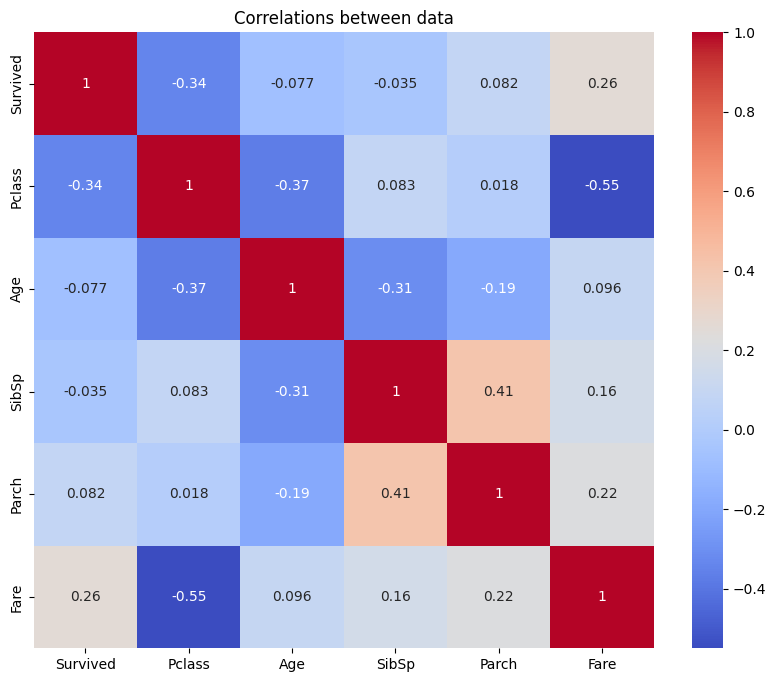

In [14]:
plt.figure(figsize=(10, 8))
plt.title("Correlations between data")

sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm')


### Impact of sex on survival

In [24]:
sex_impact_on_survival = train_df[['Sex', 'Survived']].groupby('Sex')['Survived'].mean()
print(f"[INFO] Survived:\n{sex_impact_on_survival}")

[INFO] Survived:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Correlations between sex and survival')

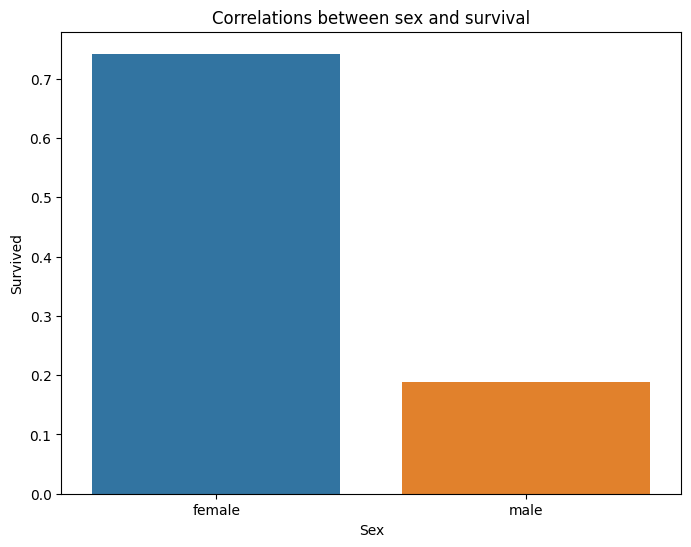

In [27]:
plt.figure(figsize=(8,6))
sns.barplot(x='Sex', y='Survived', data=sex_impact_on_survival.reset_index())
plt.title('Correlations between sex and survival')

### Impact of ticket class on survival

In [29]:
pclass_impact_on_survival = train_df[['Pclass', 'Survived']].groupby('Pclass')['Survived'].mean()
print(f"[INFO] Survived:\n{pclass_impact_on_survival}")

[INFO] Survived:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Correlations between ticket class and survival')

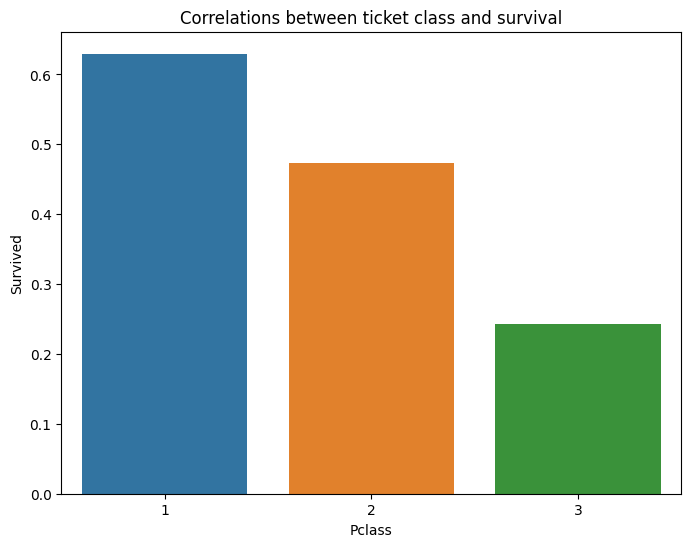

In [31]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=pclass_impact_on_survival.reset_index())
plt.title("Correlations between ticket class and survival")

### Categorical and Numerical columns

In [32]:
categorical_cols = [cname for cname in train_df.columns if train_df[cname].dtype == "object"]
numerical_cols = [cname for cname in train_df.columns if train_df[cname].dtype in ["int64", "float64"]]

print(f"[INFO] We have {len(categorical_cols)} categorical columns: {categorical_cols}")
print(f"[INFO] We have {len(numerical_cols)} numerical columns: {numerical_cols}")

[INFO] We have 5 categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
[INFO] We have 6 numerical columns: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
